In [1]:
!pip install shap
!pip install lime
!pip install transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 547.9/547.9 kB 9.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 2.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283835 sha256=0fbe910100754973f70918f80935c8646c5f916dc0815a7dfd9c5ea132ff317c
  Stored in directory: /root/.cache/pip/wheels/fd/a2/af/9ac0a1a85a27f314a06b39e1f492bee1547d52549a4606ed89
Successfully built lime
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 15.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 23.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 48.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 31.5 MB/s eta 0:00:00


In [18]:
import shap
import pickle
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.naive_bayes import MultinomialNB, GaussianNB, CategoricalNB
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier

# LIME packages
from lime import lime_text
from lime.lime_text import LimeTextExplainer
from sklearn.pipeline import make_pipeline
from lime.lime_text import IndexedString,IndexedCharacters
from lime.lime_base import LimeBase
from sklearn.linear_model import Ridge, lars_path
from lime.lime_text import explanation
from functools import partial
import scipy as sp
from sklearn.utils import check_random_state
from sklearn.metrics import classification_report, confusion_matrix

from transformers import AutoTokenizer, TFAutoModel
import tensorflow as tf
from tqdm import tqdm

In [3]:
!pip install gdown

In [4]:
'''
https://drive.google.com/file/d/1Fs0PTy_xPsoX5bg4QTCrX6JAaQCHRzis/view?usp=drive_link
https://drive.google.com/file/d/1JLa-ELhUskQINi0syf3YJWBX8jcCXdn4/view?usp=drive_link
'''

'\nhttps://drive.google.com/file/d/1Fs0PTy_xPsoX5bg4QTCrX6JAaQCHRzis/view?usp=drive_link\nhttps://drive.google.com/file/d/1JLa-ELhUskQINi0syf3YJWBX8jcCXdn4/view?usp=drive_link\n'

In [5]:
!gdown 1Fs0PTy_xPsoX5bg4QTCrX6JAaQCHRzis
!gdown 1JLa-ELhUskQINi0syf3YJWBX8jcCXdn4

Downloading...
From: https://drive.google.com/uc?id=1Fs0PTy_xPsoX5bg4QTCrX6JAaQCHRzis
To: /content/train.pkl
100% 4.09M/4.09M [00:00<00:00, 246MB/s]
Downloading...
From: https://drive.google.com/uc?id=1JLa-ELhUskQINi0syf3YJWBX8jcCXdn4
To: /content/test.pkl
100% 1.01M/1.01M [00:00<00:00, 138MB/s]


In [6]:
FILE_PATH = "train.pkl"

with open(FILE_PATH, 'rb') as f:
    df_train = pickle.load(f)

In [7]:
FILE_PATH = "test.pkl"

with open(FILE_PATH, 'rb') as f:
    df_test = pickle.load(f)

In [8]:
df_train.reset_index(drop = True, inplace = True)
df_test.reset_index(drop = True, inplace = True)

In [9]:
df_train.head()

,tweet,label,tweet_with_out_emojis,cleaned_data,Light Stemming,Root Stemming
0,شايف نفسه الحمار مع انه كان احتياط الموسم الما...,1,شايف نفسه الحمار مع انه كان احتياط الموسم الما...,شايف الحمار انه احتياط الموسم الماضي اليوفي اد...,شايف الحمار انه احتياط الموسم الماضي اليوفي اد...,شيف حمر انه حيط وسم اضي يوف دره ريل امر غرب هج...
1,: هزق البلد كلها ..مرتضي محدش عارف يوقفه ..ل...,1,: هزق البلد كلها ..مرتضي محدش عارف يوقفه ..ل...,هزق البلد مرتضي محدش عارف يوقفه لا وزير داخليه...,هزق البلد مرتضي محدش عارف يوقفه لا وزير داخليه...,هزق بلد رضي حدش عرف وقف لا وزر دخل شبب حتي بتع...
2,استفتاء : عندما تنتهي الاوليمبياد وتعود بعثتنا...,0,استفتاء : عندما تنتهي الاوليمبياد وتعود بعثتنا...,استفتاء تنتهي الاوليمبياد وتعود بعثتنا بالسلام...,استفتاء تنتهي الاوليمبياد وتعود بعثت بالسلامه ...,فاء نهي اوليمبياد تعد بعث سلم يدل حصل وجه نظر
3,Alhashemلا يوجد مخرج لنفط داعش سوي تركيا.هكذا ...,1,Alhashemلا يوجد مخرج لنفط داعش سوي تركيا.هكذا ...,لا يوجد مخرج لنفط داعش سوي تركياهكذا تقول الجغ...,لا يوجد مخرج لنفط داعش سوي تركياهكذا تقول الجغ...,لا وجد خرج نفط دعش سوي تركياهكذا تقل جغراف سؤل...
4,ما احب اركب جاهل معاي السياره عادي اتوتر طول م...,7,ما احب اركب جاهل معاي السياره عادي اتوتر طول م...,احب اركب جاهل معاي السياره عادي اتوتر طول اسوق...,احب اركب جاهل معاي السياره عادي اتوتر طول اسوق...,احب ركب جهل عاي سير عدي وتر طول اسق خيف فرح


In [14]:
label_to_class = [
    'none',
    'anger',
    'joy',
    'sadness',
    'love',
    'sympathy',
    'surprise',
    'fear'
]

In [15]:
def map_label_to_class(indices, classes):
  return [classes[idx] for idx in indices]

In [16]:
def create_confusion_matrix(y_pred):
  # creatin a confusion matrix
  y_true = map_label_to_class(df_test['label'], label_to_class)
  y_pred = map_label_to_class(y_pred, label_to_class)
  cm = confusion_matrix(y_true, y_pred, labels=label_to_class)
  # create a DataFrame for the confusion matrix with class names as index and columns
  cm_df = pd.DataFrame(cm, index=label_to_class, columns=label_to_class)

  # create a heatmap for visualization
  plt.figure(figsize=(5, 5))
  sns.heatmap(cm_df, annot=True, cmap='Blues', fmt='g')
  plt.xlabel('Predicted')
  plt.ylabel('True')
  plt.title('Confusion Matrix')
  plt.show()

## Naive Bayes Model

In [11]:
# use Tfidf Vectorizer root stemming
tfidf_vectorizer_rs = TfidfVectorizer()
# fit and transform the training data
X_train_tfidf_rs = tfidf_vectorizer_rs.fit_transform(df_train['Root Stemming'])
# transform the test data using the same vectorizer
X_test_tfidf_rs = tfidf_vectorizer_rs.transform(df_test['Root Stemming'])

# use Tfidf Vectorizer light stemming
tfidf_vectorizer_ls = TfidfVectorizer()
# fit and transform the training data
X_train_tfidf_ls = tfidf_vectorizer_ls.fit_transform(df_train['Light Stemming'])
# transform the test data using the same vectorizer
X_test_tfidf_ls = tfidf_vectorizer_ls.transform(df_test['Light Stemming'])

## Using MultinomialNB

In [19]:
nb_vec = MultinomialNB(force_alpha=True, alpha=0.1, fit_prior=True)
nb_vec.fit(X_train_tfidf_rs, df_train['label'])

# test accuracy of tf-idf vectorizer
y_pred = nb_vec.predict(X_test_tfidf_rs.toarray())
# calculating the accuracy of the classifier
accuracy = accuracy_score(df_test['label'], y_pred)
print("Accuracy:", accuracy)

Accuracy: 0.589170392449081


In [20]:
print(classification_report(df_test['label'], y_pred, target_names = label_to_class))

              precision    recall  f1-score   support

        none       0.50      0.76      0.60       307
       anger       0.58      0.72      0.64       276
         joy       0.53      0.35      0.43       268
     sadness       0.43      0.31      0.36       258
        love       0.65      0.69      0.67       250
    sympathy       0.72      0.75      0.74       194
    surprise       0.50      0.27      0.35       201
        fear       0.79      0.79      0.79       259

    accuracy                           0.59      2013
   macro avg       0.59      0.58      0.57      2013
weighted avg       0.58      0.59      0.57      2013



In [21]:
# creatin a confusion matrix
confusion_matrix(df_test['label'], y_pred)

array([[233,  18,  21,  14,   0,   2,  14,   5],
       [ 25, 199,   8,  19,   5,   9,  10,   1],
       [ 71,  21,  95,  16,  34,  11,  11,   9],
       [ 63,  34,   7,  81,  30,  14,  12,  17],
       [  3,  11,  28,  15, 173,  13,   0,   7],
       [  4,  14,   5,  12,   7, 146,   1,   5],
       [ 62,  37,   9,  14,  14,   1,  54,  10],
       [  5,  12,   6,  17,   3,   6,   5, 205]])

In [ ]:
nb_vec = MultinomialNB(force_alpha=True, alpha=0.1, fit_prior=True)
nb_vec.fit(X_train_tfidf_ls, df_train['label'])

# test accuracy of tf-idf vectorizer
y_pred = nb_vec.predict(X_test_tfidf_ls.toarray())
# calculating the accuracy of the classifier
accuracy = accuracy_score(df_test['label'], y_pred)
print("Accuracy:", accuracy)

Accuracy: 0.6035767511177347


In [ ]:
print(classification_report(df_test['label'], y_pred, target_names = label_to_class))

              precision    recall  f1-score   support

        none       0.49      0.80      0.61       307
       anger       0.63      0.67      0.65       276
         joy       0.55      0.40      0.47       268
     sadness       0.45      0.28      0.35       258
        love       0.64      0.70      0.67       250
    sympathy       0.77      0.78      0.78       194
    surprise       0.56      0.30      0.39       201
        fear       0.77      0.83      0.80       259

    accuracy                           0.60      2013
   macro avg       0.61      0.60      0.59      2013
weighted avg       0.60      0.60      0.59      2013



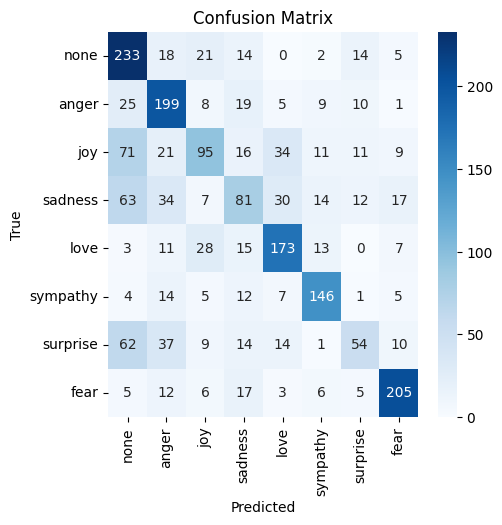

In [22]:
# creatin a confusion matrix
create_confusion_matrix(y_pred)

In [28]:
def create_csv(y_pred_idx, y_true_idx, file_path="examples.csv"):
  y_pred, y_true = map_label_to_class(y_pred_idx, label_to_class), map_label_to_class(y_true_idx, label_to_class)
  with open(file_path, 'w') as file:
    file.write('Index,True Label,Predicted Label\n')
    for i in range(len(y_pred)):
      file.write(f'{i},{y_true[i]},{y_pred[i]}\n')
  print("Content has been written to the file.")

In [24]:
y_pred

array([4, 7, 0, ..., 3, 1, 0])

In [29]:
create_csv(y_pred, df_test['label'], file_path="examples.csv")

Content has been written to the file.
